# Plot Melville Bay APEX float data: 2020-2023

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import xarray as xr
from matplotlib import cm
import matplotlib as mpl
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cmocean
from matplotlib.colors import ListedColormap
import matplotlib.font_manager as fm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import gsw

Three floats were deployed in Melville Bay (2 APEX, 1 ALAMO). The Alamo float only obtained 28 dives in less than a month in 2017. Here, I only use the APEX floats since they provide 3 years of data from 2020-2023.

APEX Float F9185 sampling period: **October 22, 2020 - December 16, 2021** <br>
APEX Float F9444 sampling period: **September 20, 2021 - November 2, 2023**

#### First, linearly interpolate lat/lon locations for gaps in GPS fixes

In [32]:
# Read in APEX float datasets
apex_dir = Path('/Volumes/OMGNarwhals/PhD_chap3/data/OMG_Float_Data/OMG_APEX_Float_Data/APEX')
F9185_data_ds = xr.open_dataset(apex_dir / 'F9185/APEX_F9185_profiles_binned.nc')
F9444_data_ds = xr.open_dataset(apex_dir / 'F9444/APEX_F9444_profiles_binned.nc')

In [33]:
# Fill any gaps in profiles (along depth dimension)
# these gaps are infrequent small gaps in the profile (e.g., when there was a brief satellite transmission issue)
float_data_ds_fill = F9185_data_ds.interpolate_na(dim='depth_bins')
# swap dims with dives and date
F9185_data_ds_fill = float_data_ds_fill.swap_dims({'dive':'date'})

# do the same for other float
float_data_ds_fill = F9444_data_ds.interpolate_na(dim='depth_bins')
# swap dims with dives and date
F9444_data_ds_fill = float_data_ds_fill.swap_dims({'dive':'date'})

In [34]:
# print start/end times for each float
print(F9185_data_ds_fill.date[0].values)
print(F9185_data_ds_fill.date[-1].values)

print(F9444_data_ds_fill.date[0].values)
print(F9444_data_ds_fill.date[-1].values)

2020-10-22T23:40:52.000000000
2021-12-16T00:04:46.000000000
2021-09-20T09:08:43.000000000
2023-11-02T01:58:08.000000000


Create new coordinate for lat/lon that includes linearly interpolated locations where nans were present

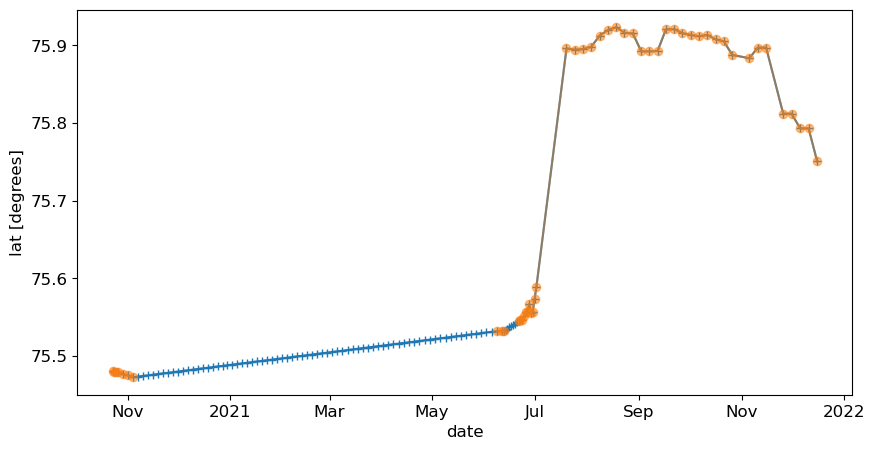

In [35]:
# Check to make sure interpolate function is doing what we want it to:
F9185_data_ds_fill.lat.interpolate_na(dim='date',method='linear').plot(marker='+')
F9185_data_ds_fill.lat.plot(marker='o',alpha=0.5)

Looks good - Now make a new coordinate in the datasets that include these new lat/lon arrays

##### F9185

In [36]:
# add new lat coord
F9185_data_ds_fill_interp = F9185_data_ds_fill.assign_coords(lat_interp=('date',F9185_data_ds_fill.lat.interpolate_na(dim='date',method='linear').values))
# add new lon coord
F9185_data_ds_fill_interp = F9185_data_ds_fill_interp.assign_coords(lon_interp=('date',F9185_data_ds_fill.lon.interpolate_na(dim='date',method='linear').values))

In [37]:
# add attributes to new coords
F9185_data_ds_fill_interp.lat_interp.attrs['units'] = 'degrees'
F9185_data_ds_fill_interp.lon_interp.attrs['units'] = 'degrees' 
F9185_data_ds_fill_interp.lat_interp.attrs['comments'] = 'Latitude of profile. Nans in "lat" coordinate have been linearly interpolated.'
F9185_data_ds_fill_interp.lon_interp.attrs['comments'] = 'Longitude of profile. Nans in "lon" coordinate have been linearly interpolated.' 

In [ ]:
# Save new dataset
F9185_data_ds_fill_interp.to_netcdf(apex_dir / '/Volumes/OMGNarwhals/PhD_chap3/data/OMG_Float_Data/OMG_APEX_Float_Data/APEX/F9185F9185/APEX_F9185_profiles_binned_gps-interpolation.nc')

##### F9444

In [39]:
# add new lat coord
F9444_data_ds_fill_interp = F9444_data_ds_fill.assign_coords(lat_interp=('date',F9444_data_ds_fill.lat.interpolate_na(dim='date',method='linear').values))
# add new lon coord
F9444_data_ds_fill_interp = F9444_data_ds_fill_interp.assign_coords(lon_interp=('date',F9444_data_ds_fill.lon.interpolate_na(dim='date',method='linear').values))

In [40]:
# add attributes to new coords
F9444_data_ds_fill_interp.lat_interp.attrs['units'] = 'degrees'
F9444_data_ds_fill_interp.lon_interp.attrs['units'] = 'degrees' 
F9444_data_ds_fill_interp.lat_interp.attrs['comments'] = 'Latitude of profile. Nans in "lat" coordinate have been linearly interpolated.'
F9444_data_ds_fill_interp.lon_interp.attrs['comments'] = 'Longitude of profile. Nans in "lon" coordinate have been linearly interpolated.' 

In [11]:
# Save new dataset
F9444_data_ds_fill_interp.to_netcdf(apex_dir / 'F9444/APEX_F9444_profiles_binned_gps-interpolation.nc')

## Plot float data profiles

Open datasets with interpolated lat/lon locations

In [48]:
# Read in APEX float datasets
apex_dir = Path('/Volumes/OMGNarwhals/PhD_chap3/data/OMG_Float_Data/OMG_APEX_Float_Data/APEX/')
F9185_data_ds = xr.open_dataset(apex_dir / 'F9185/APEX_F9185_profiles_binned_gps-interpolation.nc')
F9444_data_ds = xr.open_dataset(apex_dir / 'F9444/APEX_F9444_profiles_binned_gps-interpolation.nc')

In [49]:
# convert to TEOS-10 standards

# absolute salinity
SA = gsw.conversions.SA_from_SP(F9185_data_ds.salinity,F9185_data_ds.pressure,F9185_data_ds.lon_interp,F9185_data_ds.lat_interp)
# conservative temp
CT = gsw.conversions.CT_from_t(SA,F9185_data_ds.temperature,F9185_data_ds.pressure)
F9185_data_ds['temperature'] = CT
F9185_data_ds['salinity'] = SA

# absolute salinity
SA = gsw.conversions.SA_from_SP(F9444_data_ds.salinity,F9444_data_ds.pressure,F9444_data_ds.lon_interp,F9444_data_ds.lat_interp)
# conservative temp
CT = gsw.conversions.CT_from_t(SA,F9444_data_ds.temperature,F9444_data_ds.pressure)
F9444_data_ds['temperature'] = CT
F9444_data_ds['salinity'] = SA

### Plot temperature for each float

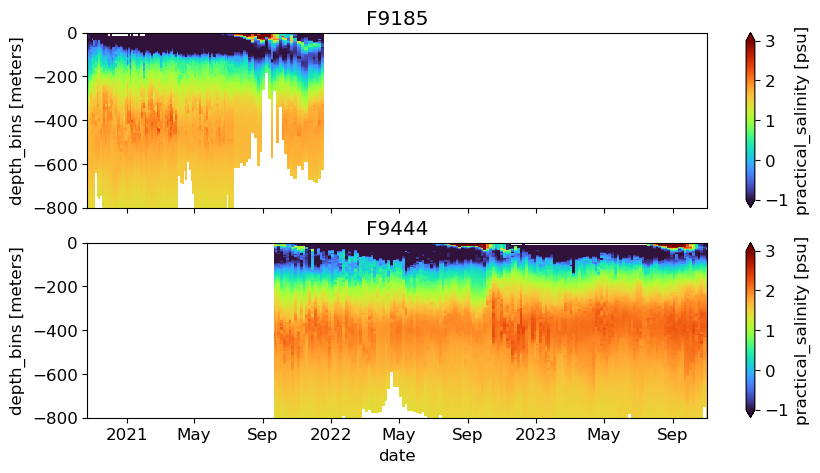

In [50]:
fig, (ax1,ax2) = plt.subplots(2,sharex=True,sharey=True)
F9185_data_ds.temperature.plot(ax=ax1,vmin=-1,vmax=3,cmap='turbo')
F9444_data_ds.temperature.plot(ax=ax2,vmin=-1,vmax=3,cmap='turbo')
ax1.set_title("F9185")
ax2.set_title("F9444")
ax1.set_xlabel("")
ax1.set_xlim(F9185_data_ds.date[0].values, F9444_data_ds.date[-1].values);
ax1.set_ylim(-800,0);

### Plot salinity for each float

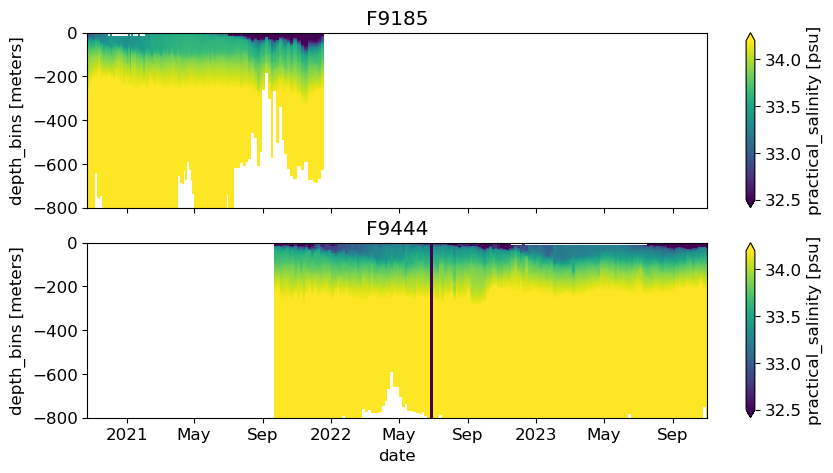

In [51]:
fig, (ax1,ax2) = plt.subplots(2,sharex=True,sharey=True)
F9185_data_ds.salinity.plot(ax=ax1,vmin=32.5,vmax=34.2,cmap='viridis')
F9444_data_ds.salinity.plot(ax=ax2,vmin=32.5,vmax=34.2,cmap='viridis')
ax1.set_title("F9185")
ax2.set_title("F9444")
ax1.set_xlabel("")
ax1.set_xlim(F9185_data_ds.date[0].values, F9444_data_ds.date[-1].values)
ax1.set_ylim(-800,0);

### See where profiles were located

In [52]:
bathy_geb = xr.open_dataset('/Volumes/OMGNarwhals/PhD_chap3/data/bathymetry/GEBCO/gebco_2021_n90.0_s30.0_w-120.0_e30.0.nc')
bathy_geb_sub = xr.open_dataset('/Volumes/OMGNarwhals/PhD_chap3/data/bathymetry/GEBCO/gebco_2021_sub_ice_n90.0_s30.0_w-120.0_e30.0.nc')

In [53]:
bathy_select = bathy_geb.elevation.isel(lat=slice(0,None,2), lon=slice(0,None,2)).sel(lat=slice(70,80), lon=slice(-75,50))
bathy_select_sub = bathy_geb_sub.elevation.isel(lat=slice(0,None,2), lon=slice(0,None,2)).sel(lat=slice(70,80), lon=slice(-75,50))

In [54]:
# identify when F9185 was pushed north
F9185_data_ds_cut = F9185_data_ds_fill.sel(date=slice('2021-7-05','2021-12-16'))

In [21]:
F9185_data_ds_fill.sel(date=slice('2021-7-01','2022-1-01'))

<xarray.Dataset> Size: 580kB
Dimensions:       (date: 30, depth_bins: 601)
Coordinates:
    dive          (date) int32 120B 131 138 139 140 141 ... 164 165 166 167 168
  * depth_bins    (depth_bins) int32 2kB -1200 -1198 -1196 -1194 ... -6 -4 -2 0
  * date          (date) datetime64[ns] 240B 2021-07-02T00:22:08 ... 2021-12-...
    lat           (date) float64 240B ...
    lon           (date) float64 240B ...
Data variables:
    pressure      (depth_bins, date) float64 144kB nan nan nan ... nan 0.03936
    temperature   (depth_bins, date) float64 144kB nan nan nan ... nan -1.782
    salinity      (depth_bins, date) float64 144kB nan nan nan ... nan 32.31
    conductivity  (depth_bins, date) float64 144kB nan nan nan ... nan 25.59
Attributes:
    Float_type:    APEX
    Float_number:  F9185

Between 2021-07-02 and 2021-07-19 the float was pushed north outside of the main trough

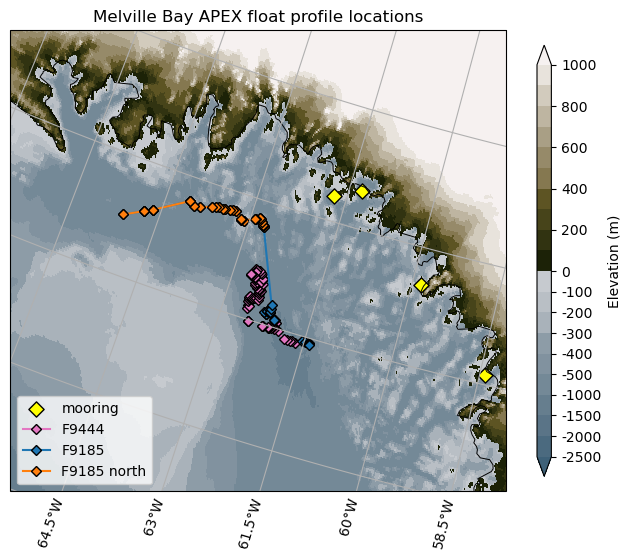

In [20]:
plt.figure(figsize=(8,8))
plt.rcParams['font.size'] = '10'

ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude = -45))
ax.set_extent([-66, -59, 75, 76.5], ccrs.PlateCarree())

# define top and bottom colormaps 
top        = cm.get_cmap(cmocean.cm.diff, 11)
bottom     = cm.get_cmap(cmocean.cm.diff_r, 12)
newcolors  = np.vstack((top(np.linspace(0.15, 0.4, 11)),
                       bottom(np.linspace(0, 0.5, 12)))) # create a new colormaps
ocean_land = ListedColormap(newcolors, name='ocean_land')
bounds     = [-2500,-2000,-1500,-1000,-500,-400,-300,-200,-100,0,100,200,300,400,500,600,700,800,900,1000]
ticks      = [-2500,-2000,-1500,-1000,-500,-400,-300,-200,-100,0,200,400,600,800,1000]

pc   = bathy_select.plot.pcolormesh('lon','lat',ax=ax,transform=ccrs.PlateCarree(),shading='auto',rasterized=True,cmap=ocean_land,levels=bounds,add_colorbar=False)
cbar = plt.colorbar(pc, label='Elevation (m)',ticks=ticks,boundaries=bounds,orientation='vertical',shrink=0.7,spacing='uniform',pad=0.05,aspect=30)
cbar.ax.set_yticklabels(ticks,rotation=0)

ax.coastlines(linewidths=0.7)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.left_labels = True
gl.right_labels = True

# add markers for mooring loccations
ax.scatter(-58.410533, 75.5413, s=60, c='yellow',edgecolor='black',marker="D",transform=ccrs.PlateCarree(), label='mooring')
ax.scatter(-59.8429, 75.843683, s=60, c='yellow',edgecolor='black',marker="D",transform=ccrs.PlateCarree()) 
ax.scatter(-61.279117, 76.160533, s=60, c='yellow',edgecolor='black',marker="D",transform=ccrs.PlateCarree())
ax.scatter(-61.726983, 76.103817, s=60, c='yellow',edgecolor='black',marker="D",transform=ccrs.PlateCarree()) 

# add apex float coordinates
ax.plot(F9444_data_ds.lon,F9444_data_ds.lat,'-D', color='tab:pink', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9444")
ax.plot(F9185_data_ds.lon,F9185_data_ds.lat,'-D', color='tab:blue', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9185")

# plot different color for profiles to identify when float drifted north
ax.plot(F9185_data_ds_cut.lon,F9185_data_ds_cut.lat,'-D', color='tab:orange', markersize=5, markeredgecolor='k',transform=ccrs.PlateCarree(), label="F9185 north")

ax.legend(loc='lower left')

plt.title("Melville Bay APEX float profile locations");

Plot profile locations with interpolated GPS coords

### Only plot profiles that were in the main trough

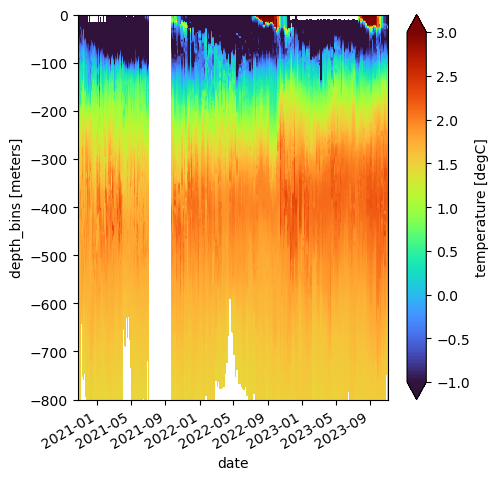

In [21]:
# fig, (ax1) = plt.subplots(1,sharex=True,sharey=True)
plt.figure(figsize=(5,5))
F9185_data_ds.sel(date=slice(F9185_data_ds.date[0].values,'2021-07-02')).temperature.plot(vmin=-1,vmax=3,cmap='turbo',add_colorbar=False)
F9444_data_ds.temperature.plot(vmin=-1,vmax=3,cmap='turbo')
plt.xlim(F9185_data_ds.date[0].values, F9444_data_ds.date[-1].values)
plt.ylim(-800,0);

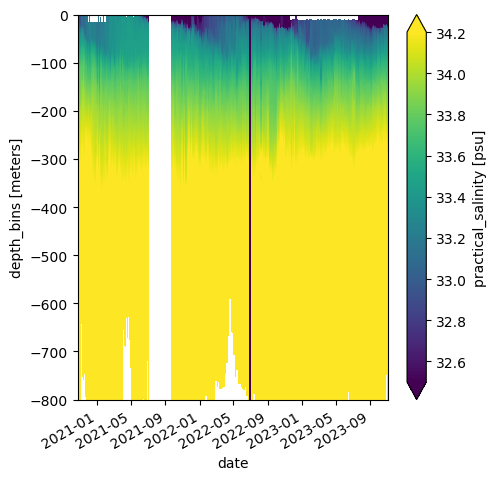

In [22]:
# fig, (ax1) = plt.subplots(1,sharex=True,sharey=True)
plt.figure(figsize=(5,5))
F9185_data_ds.sel(date=slice(F9185_data_ds.date[0].values,'2021-07-02')).salinity.plot(vmin=32.5,vmax=34.2,cmap='viridis',add_colorbar=False)
F9444_data_ds.salinity.plot(vmin=32.5,vmax=34.2,cmap='viridis')
plt.xlim(F9185_data_ds.date[0].values, F9444_data_ds.date[-1].values)
plt.ylim(-800,0);

In [23]:
# identify weird salinity profile
F9444_data_ds.sel(depth_bins=-400).where(F9444_data_ds.sel(depth_bins=-400).salinity<34, drop=True).dive.values

array([73])

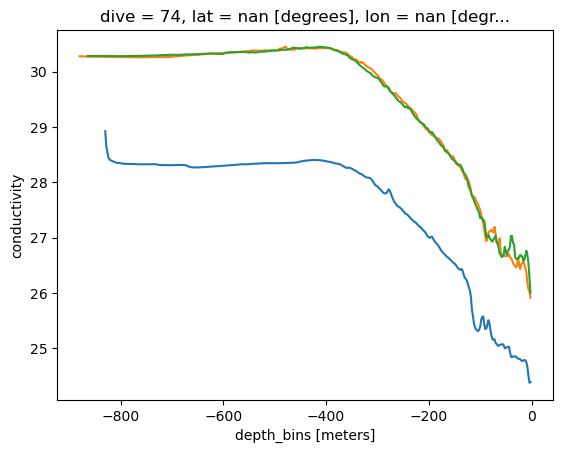

In [24]:
# look at full profile compared to neighboring ones
F9444_data_ds.swap_dims({'date':'dive'}).sel(dive=73).conductivity.plot()
F9444_data_ds.swap_dims({'date':'dive'}).sel(dive=72).conductivity.plot()
F9444_data_ds.swap_dims({'date':'dive'}).sel(dive=74).conductivity.plot();

Conductivity and salinity are lower than they should be - maybe mud or something got stuck on float and obstructed CTD sensor?

In [55]:
# remove profile 73 from dataset
F9444_data_ds_filter = F9444_data_ds.where(F9444_data_ds.date!=F9444_data_ds.swap_dims({'date':'dive'}).sel(dive=73).date.values, drop=True)

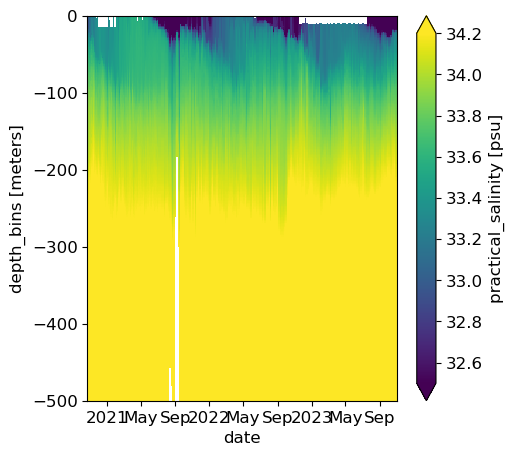

In [56]:
# now plot again
plt.figure(figsize=(5,5))
F9185_data_ds.salinity.plot(vmin=32.5,vmax=34.2,cmap='viridis',add_colorbar=False)
F9444_data_ds_filter.salinity.plot(vmin=32.5,vmax=34.2,cmap='viridis')
plt.xlim(F9185_data_ds.date[0].values, F9444_data_ds.date[-1].values)
plt.ylim(-500,0);

### Combine float datasets

Since F9444 stayed in the trough, we will use all profiles from this float, and truncate F9185

In [57]:
# trim F9185 to end on the start date of F9444
F9185_data_ds_cut = F9185_data_ds.sel(date=slice(F9185_data_ds.date.values[0],F9444_data_ds.date.values[0]))

In [58]:
# combine datasets
melville_float_ds = xr.concat((F9185_data_ds_cut, F9444_data_ds_filter), dim='date')

In [59]:
# export melville float dataset
melville_float_ds.to_netcdf('/Users/mariezahn/Documents/Work/PhD/Chapter_3/data/OMG_Float_Data/melville_apex_float_2020to2023.nc')

In [60]:
# separate profiles that were in the trough and north of the trough for F9185
F9185_data_trough_ds = F9185_data_ds.sel(date=slice(F9185_data_ds.date[0].values,'2021-07-03'))
F9185_data_north_ds  = F9185_data_ds.sel(date=slice('2021-07-03',F9444_data_ds.date.values[0]))

Load combined float dataset

In [61]:
melville_float_ds = xr.open_dataset('/Users/mariezahn/Documents/Work/PhD/Chapter_3/data/OMG_Float_Data/melville_apex_float_2020to2023.nc')

Now plot temperature and salinity profiles for combined dataset but have a color-coded label that corresponds to a map so we know which profiles were outside of the trough

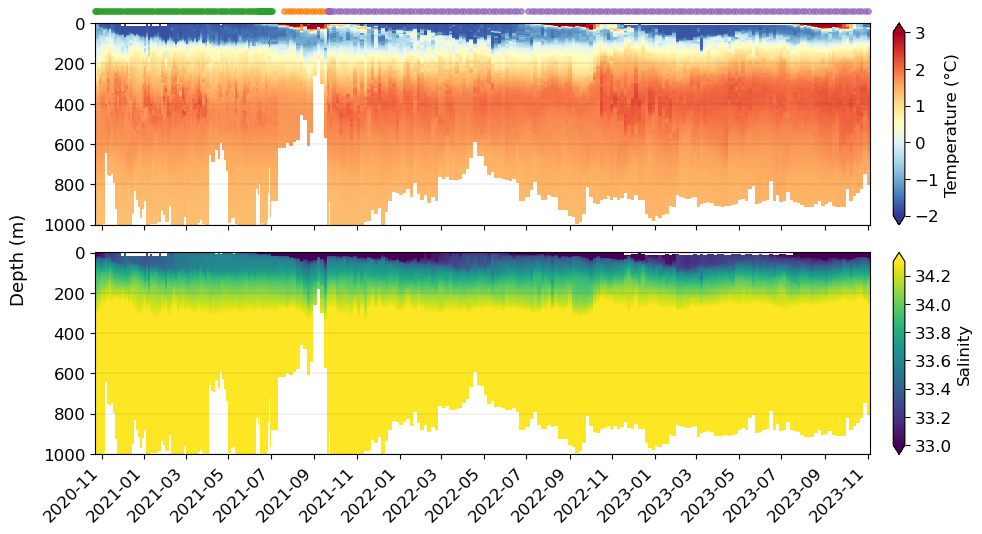

In [62]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['font.size'] = 12
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, sharex=True, sharey=False, gridspec_kw={'height_ratios': [0.1,6,0.2,6]})
plt.subplots_adjust(top=1, hspace=0.1)

# plot profile dots with color corresponding to locations on map
ax1.axis('off')
ax3.axis('off')
ax1.scatter(F9185_data_trough_ds.date.values, [0]*len(F9185_data_trough_ds.date.values), color='tab:green',  s=15, alpha=0.7, clip_on=False)
ax1.scatter(F9185_data_north_ds.date.values,  [0]*len(F9185_data_north_ds.date.values),  color='tab:orange', s=15, alpha=0.7, clip_on=False)
ax1.scatter(F9444_data_ds_filter.date.values, [0]*len(F9444_data_ds_filter.date.values), color='tab:purple', s=15, alpha=0.7, clip_on=False)

# temperature
cb_temp = melville_float_ds.temperature.sel(depth_bins=slice(-1000,0)).plot(ax=ax2,vmin=-2,vmax=3,cmap='RdYlBu_r',add_colorbar=False,extend=True)
# salinity
cb_salt = melville_float_ds.salinity.sel(depth_bins=slice(-1000,0)).plot(ax=ax4,vmin=33,vmax=34.3,cmap='viridis',add_colorbar=False)

# add colorbars
axins_temp = inset_axes(ax2,width="1.5%",height="100%",loc="upper left",bbox_to_anchor=(1.03, 0., 1, 1),bbox_transform=ax2.transAxes,borderpad=0)
cb = fig.colorbar(cb_temp, cax=axins_temp, ticks=np.arange(-2,4),extend='both',label='Temperature (°C)')

axins_salt = inset_axes(ax4,width="1.5%",height="100%",loc="upper left",bbox_to_anchor=(1.03, 0., 1, 1),bbox_transform=ax4.transAxes,borderpad=0)
cb = fig.colorbar(cb_salt, cax=axins_salt, ticks=np.arange(33,34.2,0.2),extend='both',label='Salinity')

# axes options
for ax in (ax2,ax4):
    ax.set_xlabel("");
    ax.grid(axis='y',linewidth=0.1,color='k',linestyle='dashed')
    ax.set_ylabel("")
    ax.set_yticks([0,-200,-400,-600,-800,-1000],[0,200,400,600,800,1000])
    
months   = pd.period_range(np.datetime64('2020-11'), freq='2M', periods=19).strftime('%Y-%m').tolist()
ax4.set_xticks(months, months, rotation=45, horizontalalignment = 'right');

fig.text(0.04, 0.5, 'Depth (m)', size=13, va='center', rotation='vertical');

#### Add depth averaged timeseries


# plt.savefig("C:/Users/marie/Documents/PhD/Chapter_3/OMG_manuscript_Github/OMG_Narwhals_hydrography-manuscript/Analyses-and-plots/figures/APEX_float_profiles.png", bbox_inches='tight', dpi=300, facecolor='white');

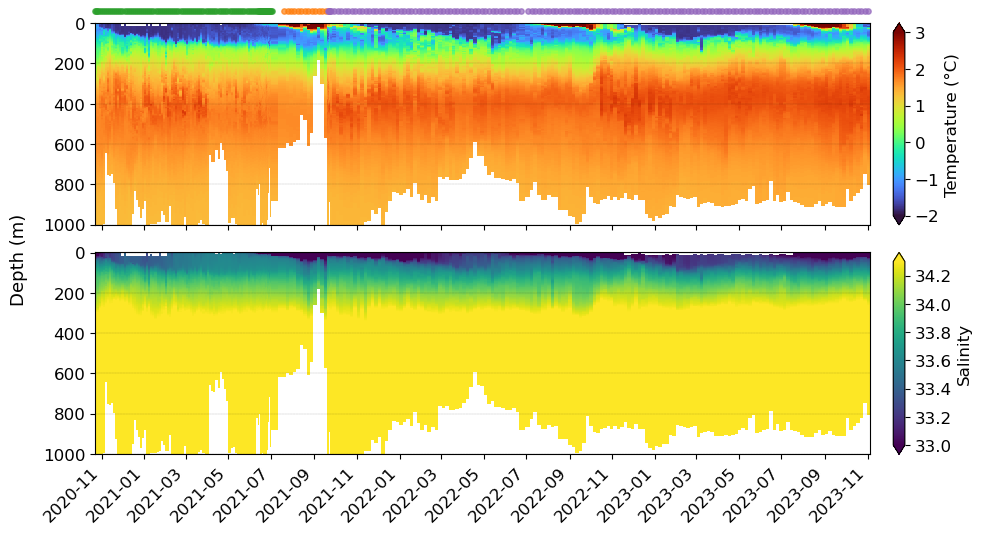

In [63]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['font.size'] = 12
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, sharex=True, sharey=False, gridspec_kw={'height_ratios': [0.1,6,0.2,6]})
plt.subplots_adjust(top=1, hspace=0.1)

# plot profile dots with color corresponding to locations on map
ax1.axis('off')
ax3.axis('off')
ax1.scatter(F9185_data_trough_ds.date.values, [0]*len(F9185_data_trough_ds.date.values), color='tab:green',  s=15, alpha=0.7, clip_on=False)
ax1.scatter(F9185_data_north_ds.date.values,  [0]*len(F9185_data_north_ds.date.values),  color='tab:orange', s=15, alpha=0.7, clip_on=False)
ax1.scatter(F9444_data_ds_filter.date.values, [0]*len(F9444_data_ds_filter.date.values), color='tab:purple', s=15, alpha=0.7, clip_on=False)

# temperature
cb_temp = melville_float_ds.temperature.sel(depth_bins=slice(-1000,0)).plot(ax=ax2,vmin=-2,vmax=3,cmap='turbo',add_colorbar=False,extend=True)
# salinity
cb_salt = melville_float_ds.salinity.sel(depth_bins=slice(-1000,0)).plot(ax=ax4,vmin=33,vmax=34.3,cmap='viridis',add_colorbar=False)

# add colorbars
axins_temp = inset_axes(ax2,width="1.5%",height="100%",loc="upper left",bbox_to_anchor=(1.03, 0., 1, 1),bbox_transform=ax2.transAxes,borderpad=0)
cb = fig.colorbar(cb_temp, cax=axins_temp, ticks=np.arange(-2,4),extend='both',label='Temperature (°C)')

axins_salt = inset_axes(ax4,width="1.5%",height="100%",loc="upper left",bbox_to_anchor=(1.03, 0., 1, 1),bbox_transform=ax4.transAxes,borderpad=0)
cb = fig.colorbar(cb_salt, cax=axins_salt, ticks=np.arange(33,34.2,0.2),extend='both',label='Salinity')

# axes options
for ax in (ax2,ax4):
    ax.set_xlabel("");
    ax.grid(axis='y',linewidth=0.1,color='k',linestyle='dashed')
    ax.set_ylabel("")
    ax.set_yticks([0,-200,-400,-600,-800,-1000],[0,200,400,600,800,1000])
    
months   = pd.period_range(np.datetime64('2020-11'), freq='2M', periods=19).strftime('%Y-%m').tolist()
ax4.set_xticks(months, months, rotation=45, horizontalalignment = 'right');

fig.text(0.04, 0.5, 'Depth (m)', size=13, va='center', rotation='vertical');

#### Add depth averaged timeseries


# plt.savefig("C:/Users/marie/Documents/PhD/Chapter_3/OMG_manuscript_Github/OMG_Narwhals_hydrography-manuscript/Analyses-and-plots/figures/APEX_float_profiles.png", bbox_inches='tight', dpi=300, facecolor='white');

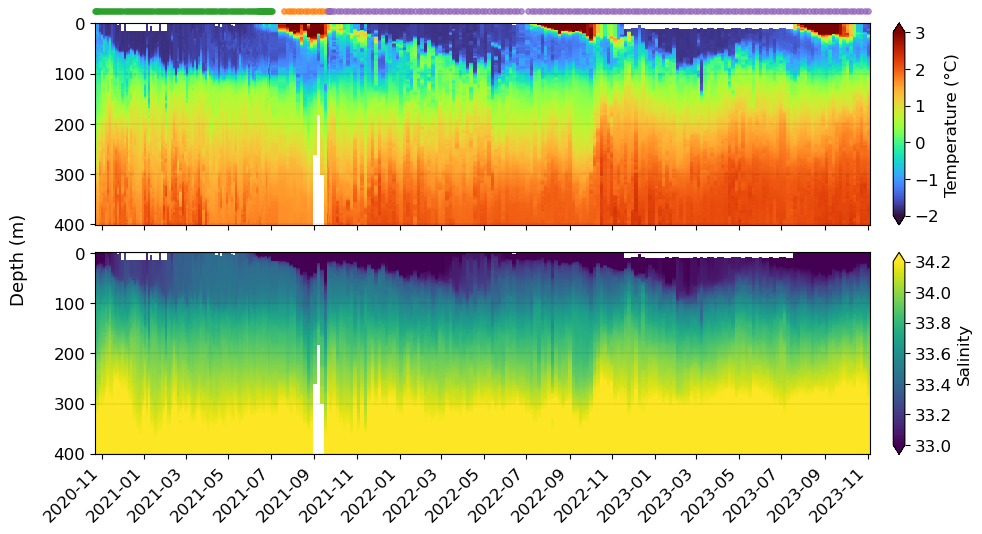

In [39]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['font.size'] = 12
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, sharex=True, sharey=False, gridspec_kw={'height_ratios': [0.1,6,0.2,6]})
plt.subplots_adjust(top=1, hspace=0.1)

# plot profile dots with color corresponding to locations on map
ax1.axis('off')
ax3.axis('off')
ax1.scatter(F9185_data_trough_ds.date.values, [0]*len(F9185_data_trough_ds.date.values), color='tab:green',  s=15, alpha=0.7, clip_on=False)
ax1.scatter(F9185_data_north_ds.date.values,  [0]*len(F9185_data_north_ds.date.values),  color='tab:orange', s=15, alpha=0.7, clip_on=False)
ax1.scatter(F9444_data_ds_filter.date.values, [0]*len(F9444_data_ds_filter.date.values), color='tab:purple', s=15, alpha=0.7, clip_on=False)

# temperature
# cb_temp = melville_float_ds.temperature.sel(depth_bins=slice(-400,0)).plot(ax=ax2,vmin=-2,vmax=3,cmap='RdYlBu_r',add_colorbar=False,extend=True)
cb_temp = melville_float_ds.temperature.sel(depth_bins=slice(-400,0)).plot(ax=ax2,vmin=-2,vmax=3,cmap='turbo',add_colorbar=False,extend=True)
# salinity
cb_salt = melville_float_ds.salinity.sel(depth_bins=slice(-400,0)).plot(ax=ax4,vmin=33,vmax=34.2,cmap='viridis',add_colorbar=False)

# add colorbars
axins_temp = inset_axes(ax2,width="1.5%",height="100%",loc="upper left",bbox_to_anchor=(1.03, 0., 1, 1),bbox_transform=ax2.transAxes,borderpad=0)
cb = fig.colorbar(cb_temp, cax=axins_temp, ticks=np.arange(-2,4),extend='both',label='Temperature (°C)')

axins_salt = inset_axes(ax4,width="1.5%",height="100%",loc="upper left",bbox_to_anchor=(1.03, 0., 1, 1),bbox_transform=ax4.transAxes,borderpad=0)
cb = fig.colorbar(cb_salt, cax=axins_salt, ticks=np.arange(33,34.2,0.2),extend='both',label='Salinity')

# axes options
for ax in (ax2,ax4):
    ax.set_xlabel("");
    ax.grid(axis='y',linewidth=0.1,color='k',linestyle='dashed')
    ax.set_ylabel("")
    ax.set_yticks([0,-100,-200,-300,-400],[0,100,200,300,400])
    
months   = pd.period_range(np.datetime64('2020-11'), freq='2M', periods=19).strftime('%Y-%m').tolist()
ax4.set_xticks(months, months, rotation=45, horizontalalignment = 'right');

fig.text(0.04, 0.5, 'Depth (m)', size=13, va='center', rotation='vertical');

#### Add depth averaged timeseries


# plt.savefig("C:/Users/marie/Documents/PhD/Chapter_3/OMG_manuscript_Github/OMG_Narwhals_hydrography-manuscript/Analyses-and-plots/figures/APEX_float_profiles.png", bbox_inches='tight', dpi=300, facecolor='white');

220-240 m

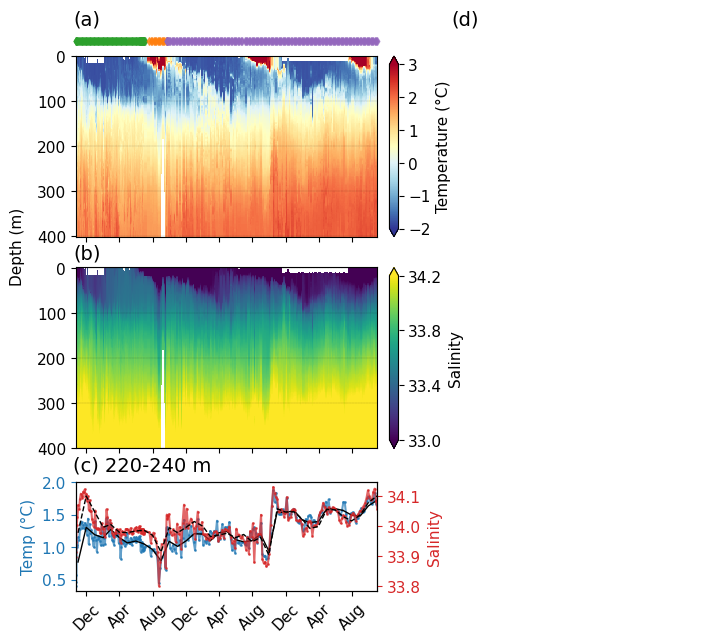

In [21]:
# make custom grid for multi-panel plot
gs_kw = dict(width_ratios=[1.5, 1], height_ratios=[0.01, 1, 1, 0.015, 0.6], wspace=0.1)
fig, axd = plt.subplot_mosaic([['ax1', 'ax2'],
                               ['ax3', 'ax5'],
                               ['ax4', 'ax5'],
                               ['space', 'space'],
                               ['ax6', 'ax7']],
                              gridspec_kw=gs_kw,figsize=(7, 6),\
                              layout="constrained")

plt.rcParams['font.size'] = 11

# plot profile dots with color corresponding to locations on map
axd['ax1'].axis('off')
axd['ax2'].axis('off')
axd['ax7'].axis('off')
axd['space'].axis('off')
axd['ax1'].scatter(F9185_data_trough_ds.date.values, [0]*len(F9185_data_trough_ds.date.values), marker='d', color='tab:green',  s=15, alpha=0.7, clip_on=False)
axd['ax1'].scatter(F9185_data_north_ds.date.values,  [0]*len(F9185_data_north_ds.date.values),  marker='d', color='tab:orange', s=15, alpha=0.7, clip_on=False)
axd['ax1'].scatter(F9444_data_ds_filter.date.values, [0]*len(F9444_data_ds_filter.date.values), marker='d', color='tab:purple', s=15, alpha=0.7, clip_on=False)

# temperature
cb_temp = melville_float_ds.temperature.sel(depth_bins=slice(-400,0)).plot(ax=axd['ax3'],vmin=-2,vmax=3,cmap='RdYlBu_r',add_colorbar=False,extend=True)
# salinity
cb_salt = melville_float_ds.salinity.sel(depth_bins=slice(-400,0)).plot(ax=axd['ax4'],vmin=33,vmax=34.2,cmap='viridis',add_colorbar=False)

# add colorbars
axins_temp = inset_axes(axd['ax3'],width="3%",height="100%",loc="upper left",bbox_to_anchor=(1.04, 0., 1, 1),bbox_transform=axd['ax3'].transAxes,borderpad=0)
cb = fig.colorbar(cb_temp, cax=axins_temp, ticks=np.arange(-2,4),extend='both',label='Temperature (°C)')

axins_salt = inset_axes(axd['ax4'],width="3%",height="100%",loc="upper left",bbox_to_anchor=(1.04, 0., 1, 1),bbox_transform=axd['ax4'].transAxes,borderpad=0)
cb = fig.colorbar(cb_salt, cax=axins_salt, ticks=np.arange(33,34.2,0.4),extend='both',label='Salinity')

#### Add depth averaged timeseries
melville_float_ds_select = melville_float_ds.sel(depth_bins=slice(-240,-220)).mean(dim='depth_bins', skipna=True)
# add temperature with monthly mean
melville_float_ds_select.temperature.plot(marker='.',markersize=2,ax=axd['ax6'],alpha=0.7,label="220-240 m")
melville_float_ds_select.temperature.resample(date='1M').mean().plot(ax=axd['ax6'],color='k', linestyle='solid',linewidth=1)
# axd['ax6'].legend(loc='lower right',fontsize=9,frameon=False)

# add salinity with monthly mean
# make secondary axis
ax6_twin = axd['ax6'].twinx()
melville_float_ds_select.salinity.plot(marker='.',markersize=2,ax=ax6_twin,color='tab:red',alpha=0.7,label="220-240 m")
melville_float_ds_select.salinity.resample(date='1M').mean().plot(ax=ax6_twin,color='k', linestyle='dashed',linewidth=1)

# axes options
months   = pd.period_range(np.datetime64('2020-12'), freq='4M', periods=9).strftime('%Y-%m').tolist()
for ax in (axd['ax3'],axd['ax4']):
    ax.set_xlabel("");
    ax.grid(axis='y',linewidth=0.1,color='k',linestyle='dashed')
    ax.set_ylabel("")
    ax.set_yticks([0,-100,-200,-300,-400],[0,100,200,300,400])
    ax.set_xticks(months, [])

for ax in (axd['ax1'],axd['ax3'],axd['ax4'],axd['ax6']):
    ax.set_xlim(melville_float_ds.isel(date=0).date, melville_float_ds.isel(date=-1).date);

fig.text(-0.01, 0.65, 'Depth (m)', size=11, va='center', rotation='vertical');

# set bottom axis labels
axd['ax6'].set_xlabel("")
axd['ax6'].set_yticks([0.5,1.0,1.5,2])
axd['ax6'].set_xticks(months, ['Dec','Apr','Aug','Dec','Apr','Aug','Dec','Apr','Aug'], \
                      rotation=45, horizontalalignment = 'center');
axd['ax6'].set_ylabel("Temp (°C)", color='tab:blue')
axd['ax6'].tick_params(axis='y', colors='tab:blue')
ax6_twin.set_yticks([33.8,33.9,34.0,34.1])
ax6_twin.set_ylabel("Salinity", color='tab:red')
ax6_twin.tick_params(axis='y', colors='tab:red')

# add labels
fig.text(0.08,1.02,('(a)'),size=14)
fig.text(0.08,0.63,('(b)'),size=14)
fig.text(0.08,0.275,('(c) 220-240 m'),size=14)
fig.text(0.62,1.02,('(d)'),size=14);

axd['ax5'].axis('off');

plt.savefig("/Users/mariezahn/Documents/Work/PhD/Chapter_3/OMG_manuscript_Github/OMG_Narwhals_hydrography-manuscript/02_analyses-and-plots/figures/APEX_float_profiles_multiplot.png", bbox_inches='tight', dpi=300, facecolor='white');

320-380 m

In [65]:
## import netcdfs from ecco analyses
theta_row150_month_320m_norm = xr.open_dataset("../ecco_melville/temp_detrend_norm_nc/ecco_theta_row150_month_320m_norm.nc")
apex_temp_month_320m_norm = xr.open_dataset("../ecco_melville/temp_detrend_norm_nc/apex_temp_month_320m_norm.nc")
mooring_temp_month_320m_norm = xr.open_dataset("../ecco_melville/temp_detrend_norm_nc/mooring_temp_month_320m_norm.nc")

In [66]:
## it doesn't make sense to me why I need to change the month coordinate back to numeric values and then back to an object in order to plot...but this works
theta_row150_month_320m_norm = theta_row150_month_320m_norm.assign_coords({'month':[5,6,7,8,9,10,11,12,1,2,3,4]}).sel(month=[5,6,7,8,9,10,11,12,1,2,3,4])
apex_temp_month_320m_norm = apex_temp_month_320m_norm.assign_coords({'month':[5,6,7,8,9,10,11,12,1,2,3,4]}).sel(month=[5,6,7,8,9,10,11,12,1,2,3,4])
mooring_temp_month_320m_norm = mooring_temp_month_320m_norm.assign_coords({'month':[5,6,7,8,9,10,11,12,1,2,3,4]}).sel(month=[5,6,7,8,9,10,11,12,1,2,3,4])

theta_row150_month_320m_norm['month'] = ['May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr']
apex_temp_month_320m_norm['month'] = ['May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr']
mooring_temp_month_320m_norm['month'] = ['May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr']

/opt/anaconda3/envs/omg-narwhals/lib/python3.9/site-packages/xarray/core/groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
/opt/anaconda3/envs/omg-narwhals/lib/python3.9/site-packages/xarray/core/groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


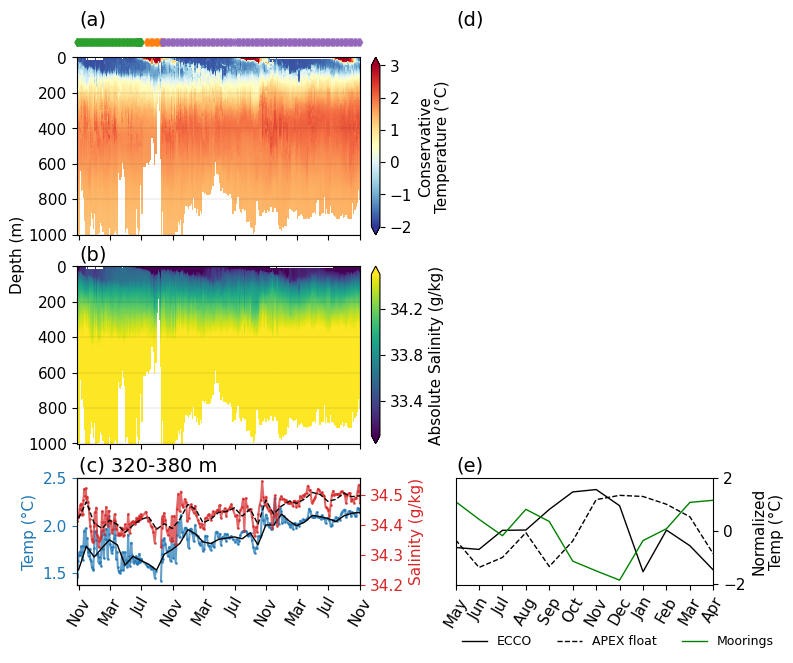

In [69]:
# make custom grid for multi-panel plot
gs_kw = dict(width_ratios=[1.1, 1], height_ratios=[0.01, 1, 1, 0.017, 0.6], wspace=0.02)
fig, axd = plt.subplot_mosaic([['ax1', 'ax2'],
                               ['ax3', 'ax5'],
                               ['ax4', 'ax5'],
                               ['space', 'space'],
                               ['ax6', 'ax7']],
                              gridspec_kw=gs_kw,figsize=(7.7, 6.2),\
                              layout="constrained")

plt.rcParams['font.size'] = 11

# plot profile dots with color corresponding to locations on map
axd['ax1'].axis('off')
axd['ax2'].axis('off')
# axd['ax7'].axis('off')
axd['space'].axis('off')
axd['ax1'].scatter(F9185_data_trough_ds.date.values, [0]*len(F9185_data_trough_ds.date.values), marker='d', color='tab:green',  s=15, alpha=0.7, clip_on=False)
axd['ax1'].scatter(F9185_data_north_ds.date.values,  [0]*len(F9185_data_north_ds.date.values),  marker='d', color='tab:orange', s=15, alpha=0.7, clip_on=False)
axd['ax1'].scatter(F9444_data_ds_filter.date.values, [0]*len(F9444_data_ds_filter.date.values), marker='d', color='tab:purple', s=15, alpha=0.7, clip_on=False)

# temperature
cb_temp = melville_float_ds.temperature.sel(depth_bins=slice(-1000,0)).plot(ax=axd['ax3'],vmin=-2,vmax=3,cmap='RdYlBu_r',add_colorbar=False,extend=True)
# salinity
cb_salt = melville_float_ds.salinity.sel(depth_bins=slice(-1000,0)).plot(ax=axd['ax4'],vmin=33.1,vmax=34.5,cmap='viridis',add_colorbar=False)

# add colorbars
axins_temp = inset_axes(axd['ax3'],width="3%",height="100%",loc="upper left",bbox_to_anchor=(1.04, 0., 1, 1),bbox_transform=axd['ax3'].transAxes,borderpad=0)
cb = fig.colorbar(cb_temp, cax=axins_temp, ticks=np.arange(-2,4),extend='both',label='Conservative\nTemperature (°C)')

axins_salt = inset_axes(axd['ax4'],width="3%",height="100%",loc="upper left",bbox_to_anchor=(1.04, 0., 1, 1),bbox_transform=axd['ax4'].transAxes,borderpad=0)
cb = fig.colorbar(cb_salt, cax=axins_salt, ticks=np.arange(33,34.2,0.4),extend='both',label='Absolute Salinity (g/kg)')

#### Add depth averaged timeseries
melville_float_ds_select = melville_float_ds.sel(depth_bins=slice(-380,-320)).mean(dim='depth_bins', skipna=True)
# add temperature with monthly mean
melville_float_ds_select.temperature.plot(marker='.',markersize=2,ax=axd['ax6'],alpha=0.7,label="320-380 m")
melville_float_ds_select.temperature.resample(date='1M').mean().plot(ax=axd['ax6'],color='k', linestyle='solid',linewidth=1)
# axd['ax6'].legend(loc='lower right',fontsize=9,frameon=False)

# add salinity with monthly mean
# make secondary axis
ax6_twin = axd['ax6'].twinx()
melville_float_ds_select.salinity.plot(marker='.',markersize=2,ax=ax6_twin,color='tab:red',alpha=0.7,label="320-380 m")
melville_float_ds_select.salinity.resample(date='1M').mean().plot(ax=ax6_twin,color='k', linestyle='dashed',linewidth=1)

# axes options
months   = pd.period_range(np.datetime64('2020-11'), freq='4M', periods=10).strftime('%Y-%m').tolist()
for ax in (axd['ax3'],axd['ax4']):
    ax.set_xlabel("");
    ax.grid(axis='y',linewidth=0.1,color='k',linestyle='dashed')
    ax.set_ylabel("")
    ax.set_yticks([0,-200,-400,-600,-800,-1000],[0,200,400,600,800,1000])
    ax.set_xticks(months, [])

for ax in (axd['ax1'],axd['ax3'],axd['ax4'],axd['ax6']):
    ax.set_xlim(melville_float_ds.isel(date=0).date, melville_float_ds.isel(date=-1).date);

fig.text(-0.01, 0.65, 'Depth (m)', size=11, va='center', rotation='vertical');

# set bottom axis labels
axd['ax6'].set_xlabel("")
axd['ax6'].set_yticks([1.5,2,2.5])
# axd['ax6'].set_xticks(months, ['Dec','Apr','Aug','Dec','Apr','Aug','Dec','Apr','Aug'], \
#                       rotation=60, horizontalalignment = 'center');
axd['ax6'].set_xticks(months, ['Nov','Mar','Jul','Nov','Mar','Jul','Nov','Mar','Jul','Nov'], \
                      rotation=60, horizontalalignment = 'center');
axd['ax6'].set_ylabel("Temp (°C)", color='tab:blue')
axd['ax6'].tick_params(axis='y', colors='tab:blue')
ax6_twin.set_yticks([34.2,34.3,34.4,34.5])
ax6_twin.set_ylabel("Salinity (g/kg)", color='tab:red')
ax6_twin.tick_params(axis='y', colors='tab:red')

# add comparison between ecco, float, and mooring data
theta_row150_month_320m_norm.theta.plot(ax=axd['ax7'],color='k', linestyle='solid',linewidth=1,label='ECCO')
apex_temp_month_320m_norm.temperature.plot(ax=axd['ax7'],color='k', linestyle='dashed',linewidth=1,label='APEX float')
mooring_temp_month_320m_norm.temperature.plot(ax=axd['ax7'],color='g', linestyle='solid',linewidth=1,label='Moorings')

axd['ax7'].set_yticks([-2,0,2])
axd['ax7'].margins(x=0)
axd['ax7'].set_ylabel("Normalized\nTemp (°C)")
axd['ax7'].set_xlabel("")
axd['ax7'].yaxis.set_label_position("right")
axd['ax7'].yaxis.tick_right()
axd['ax7'].set_xticks(theta_row150_month_320m_norm.month.values,theta_row150_month_320m_norm.month.values,
                      rotation=60, horizontalalignment = 'center');

axd['ax7'].legend(loc="lower left",fontsize=9,ncol=3,bbox_to_anchor=[-0.02, -0.7],frameon=False);

# add labels
fig.text(0.08,1.02,('(a)'),size=14)
fig.text(0.08,0.64,('(b)'),size=14)
fig.text(0.08,0.3,('(c) 320-380 m'),size=14)
fig.text(0.57,1.02,('(d)'),size=14);
fig.text(0.57,0.3,('(e)'),size=14)

axd['ax5'].axis('off');

plt.savefig("/Users/mariezahn/Documents/Work/PhD/Chapter_3/OMG_manuscript_Github/OMG_Narwhals_hydrography-manuscript/02_analyses-and-plots/figures/APEX_float_profiles_multiplot.png", bbox_inches='tight', dpi=300, facecolor='white');

Plot map that links profile locations to the profiles plotted above (i.e., so we know where these profiles were located)

In [21]:
bathy_select = bathy_geb.elevation.isel(lat=slice(0,None,2), lon=slice(0,None,2)).sel(lat=slice(70,80), lon=slice(-75,50))
bathy_select_sub = bathy_geb_sub.elevation.isel(lat=slice(0,None,2), lon=slice(0,None,2)).sel(lat=slice(70,80), lon=slice(-75,50))

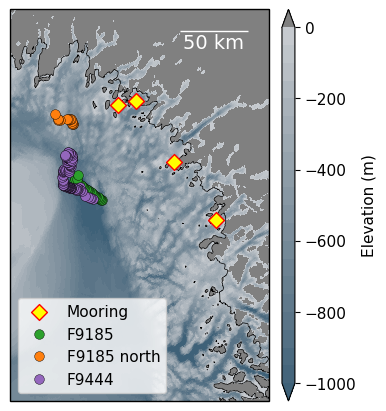

In [22]:
fig = plt.figure(figsize=(3,4), constrained_layout=True)
plt.rcParams['font.size'] = '11'
ax = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -45))
ax.set_extent([-62.5, -58.05, 74.35, 76.7], ccrs.PlateCarree())

# define top and bottom colormaps 
bathy = cm.get_cmap(cmocean.cm.diff, 21) # original option
surface = (.5, .5, .5, 1.0)
newcolors = np.vstack((bathy(np.linspace(0.15, 0.4, 21)),
                       surface)) # create a new colormaps
ocean_land = ListedColormap(newcolors, name='ocean_land')
bounds = [-1000,-950,-900,-850,-800,-750,-700,-650,-600,-550,-500,-450,-400,-350,-300,-250,-200,-150,-100,-50,0]
ticks = [-1000,-800,-600,-400,-200,0]

pc = bathy_select_sub.plot.pcolormesh('lon','lat',ax=ax,transform=ccrs.PlateCarree(),shading='auto',rasterized=True,cmap=ocean_land,levels=bounds,add_colorbar=False,zorder=2)
# add colorbar
axins_map = inset_axes(ax,width="5%",height="100%",loc="upper left",bbox_to_anchor=(1.05, 0., 1, 1),bbox_transform=ax.transAxes,borderpad=0)
cbar = plt.colorbar(pc, cax=axins_map, label='Elevation (m)',ticks=ticks,boundaries=bounds,orientation='vertical',pad=0.8)
# cbar.ax.tick_params(labelsize=8) 
# add coastline
bathy_select.plot.contour('lon','lat', levels=[0], ax=ax,transform=ccrs.PlateCarree(),colors='k',linewidths=0.5)

# add markers for mooring loccations
ax.scatter(-58.410533, 75.5413,   s=65, c='yellow',edgecolor='r',marker="D",transform=ccrs.PlateCarree(),label='Mooring') # FOR LEGEND
ax.scatter(-58.410533, 75.5413,   s=65, c='yellow',edgecolor='r',marker="D",transform=ccrs.PlateCarree(),zorder=5) # sverdrup
ax.scatter(-59.8429, 75.843683,   s=65, c='yellow',edgecolor='r',marker="D",transform=ccrs.PlateCarree(),zorder=5) # kong oscar
ax.scatter(-61.279117, 76.160533, s=65, c='yellow',edgecolor='r',marker="D",transform=ccrs.PlateCarree(),zorder=5) # rink
ax.scatter(-61.726983, 76.103817, s=65, c='yellow',edgecolor='r',marker="D",transform=ccrs.PlateCarree(),zorder=5) # fisher islands

# add apex float coordinates
# select every few points because they are so tightly clustered it is hard to see them on the map
ax.plot(F9185_data_trough_ds.isel(date=slice(0,None,4)).lon_interp,F9185_data_trough_ds.isel(date=slice(0,None,4)).lat_interp,'o', color='tab:green', \
        markersize=7, markeredgecolor='k', markeredgewidth=0.3, transform=ccrs.PlateCarree(), label="F9185")
# plot last point
ax.plot(F9185_data_trough_ds.isel(date=-1).lon_interp,F9185_data_trough_ds.isel(date=-1).lat_interp,'o', color='tab:green', \
        markersize=7, markeredgecolor='k', markeredgewidth=0.3, transform=ccrs.PlateCarree())
# plot different color for profiles to identify when float drifted north
ax.plot(F9185_data_north_ds.lon,F9185_data_north_ds.lat,'o', color='tab:orange', markersize=7, \
        markeredgecolor='k',markeredgewidth=0.3,transform=ccrs.PlateCarree(), label="F9185 north")
ax.plot(F9444_data_ds_filter.lon_interp,F9444_data_ds_filter.lat_interp,'o', color='tab:purple', \
        markersize=7, markeredgecolor='k', markeredgewidth=0.3, transform=ccrs.PlateCarree(), label="F9444")

# thicken map border
ax.spines['geo'].set_linewidth(1)
ax.spines['geo'].set_edgecolor('k')

# add manual legend
# ax.legend(prop={'size': 13},bbox_to_anchor=(-0.65, 1), loc='upper left',frameon=False);
ax.legend(prop={'size': 11},loc='lower left');

# add scale bar for map
fontprops = fm.FontProperties(size=14)
scalebar = AnchoredSizeBar(ax.transData,50000,'50 km','upper right',pad=1,color='white',frameon=False,size_vertical=200,fontproperties=fontprops)
ax.add_artist(scalebar);

plt.savefig("C:/Users/marie/Documents/PhD/Chapter_3/OMG_manuscript_Github/OMG_Narwhals_hydrography-manuscript/02_analyses-and-plots/figures/APEX_float_map.png", bbox_inches='tight', dpi=300, facecolor='white');

## Plot temperature and salinity for specified depths

Initial look at several depths:

In [ ]:
melville_float_ds.sel(depth_bins=slice(-240,-220)).mean(dim='depth_bins', skipna=True).temperature.plot(label='220-240m')
melville_float_ds.sel(depth_bins=slice(-140,-120)).mean(dim='depth_bins', skipna=True).temperature.plot(label='120-140m')
melville_float_ds.sel(depth_bins=slice(-80,-60)).mean(dim='depth_bins',   skipna=True).temperature.plot(label='60-80m')
melville_float_ds.sel(depth_bins=slice(-40,-20)).mean(dim='depth_bins',   skipna=True).temperature.plot(label='20-40m')
plt.grid(linewidth=0.3)
plt.legend();

In [ ]:
melville_float_ds.sel(depth_bins=slice(-380,-320)).mean(dim='depth_bins', skipna=True).salinity.plot(label='320-380m')
melville_float_ds.sel(depth_bins=slice(-240,-220)).mean(dim='depth_bins', skipna=True).salinity.plot(label='220-240m')
melville_float_ds.sel(depth_bins=slice(-140,-120)).mean(dim='depth_bins', skipna=True).salinity.plot(label='120-140m')
melville_float_ds.sel(depth_bins=slice(-80,-60)).mean(dim='depth_bins',   skipna=True).salinity.plot(label='60-80m')
melville_float_ds.sel(depth_bins=slice(-40,-20)).mean(dim='depth_bins',   skipna=True).salinity.plot(label='20-40m')
plt.grid(linewidth=0.3)
plt.legend();